In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


random forest models modified. changed criterion to absolute error

In [2]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        diff = df - df_shifted.interpolate(method='spline', limit_direction='backward', order=1)
        diff = diff.drop('weekofyear', axis=1)
        for cname in diff.columns:
            diff.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)

        df_res = df_res.join(diff)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k',
       'reanalysis_specific_humidity_g_per_kg']
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)


def iq_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm']

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [3]:
sj_tminus = 26
iq_tminus = 26
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

In [4]:
sj_X_train - sj_X_train.shift(6).interpolate(method='spline', limit_direction='backward', order=1)

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,ndvi_nw_2,...,reanalysis_dew_point_temp_k_24,reanalysis_specific_humidity_g_per_kg_24,ndvi_nw_25,ndvi_se_25,reanalysis_dew_point_temp_k_25,reanalysis_specific_humidity_g_per_kg_25,ndvi_nw_26,ndvi_se_26,reanalysis_dew_point_temp_k_26,reanalysis_specific_humidity_g_per_kg_26
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,6.157648,-0.045519,0.019491,-2.438880,-2.184941,-0.044867,0.019342,-2.556953,-2.529083,-0.045043,...,-1.282838,-1.291915,-0.043859,0.019506,-1.348929,-1.369028,-0.043809,0.019496,-1.372731,-1.572650
1990-05-07,6.147624,-0.006898,-0.016632,-0.976745,-0.906553,0.038336,-0.036267,1.530061,1.353654,-0.006421,...,0.061656,-0.110640,-0.005240,-0.016618,-0.002401,-0.183713,-0.005192,-0.016628,-0.023075,-0.363670
1990-05-14,6.137600,0.024064,-0.021787,0.431105,0.487549,0.030678,-0.005297,1.475796,1.469389,0.069124,...,1.351864,1.186349,0.025719,-0.021772,1.289841,1.117316,0.025768,-0.021782,1.272295,0.961025
1990-05-21,6.127576,0.096334,0.048573,0.231813,0.230223,0.071987,0.070217,-0.131325,-0.182020,0.102776,...,1.034930,0.831909,0.097987,0.048587,0.974940,0.766917,0.098036,0.048577,0.960522,0.634292
1990-05-28,6.117552,0.113637,0.072218,0.668234,0.685753,0.017022,0.023504,0.504410,0.530857,0.089119,...,1.353709,1.190326,0.115289,0.072233,1.295753,1.129375,0.115337,0.072223,1.284463,1.020415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,6.000000,0.023200,0.160271,-0.845714,-0.722857,-0.004450,0.291486,-1.514286,-1.234286,0.029000,...,-1.148571,-1.098571,0.091133,0.262300,-0.687143,-0.535714,0.032390,0.134900,-0.432857,-0.292857
2008-04-01,6.000000,0.078233,-0.126686,0.101429,0.124286,0.055033,-0.286957,0.947143,0.847143,0.050583,...,0.192857,0.148571,0.038000,-0.093671,-0.201429,-0.251429,0.146167,-0.024657,0.260000,0.311429
2008-04-08,6.000000,-0.068170,-0.073872,0.230000,0.217143,-0.146403,0.052814,0.128571,0.092857,-0.091370,...,0.644286,0.661429,-0.157537,-0.091481,0.321429,0.241429,-0.108403,-0.040857,-0.072857,-0.158571


# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [5]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [6]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
reanalysis_dew_point_temp_k,655.0,295.067408,1.566198,289.642857,293.840714,295.447143,296.355714,297.467143
reanalysis_specific_humidity_g_per_kg,655.0,16.508540,1.547369,11.715714,15.237143,16.837143,17.805714,19.044286
...,...,...,...,...,...,...,...,...
reanalysis_specific_humidity_g_per_kg_25,655.0,0.075528,2.846152,-6.994286,-2.449286,0.317143,2.436429,6.515714
ndvi_nw_26,655.0,-0.005391,0.098423,-0.335300,-0.069254,-0.004900,0.052233,0.382067
ndvi_se_26,655.0,0.000769,0.071019,-0.245200,-0.046999,0.003533,0.044890,0.228043
reanalysis_dew_point_temp_k_26,655.0,0.083750,2.872839,-7.158571,-2.442857,0.312857,2.427857,7.248571


In [7]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,286.0,25.321678,14.994315,1.000000,12.250000,24.000000,38.000000,53.000000
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
reanalysis_air_temp_k,286.0,297.842963,1.097544,294.635714,297.162500,297.807857,298.459286,301.175714
reanalysis_dew_point_temp_k,286.0,295.519940,1.404300,290.088571,294.573571,295.975714,296.575357,297.852857
...,...,...,...,...,...,...,...,...
reanalysis_tdtr_k_26,286.0,-0.230120,4.049490,-9.642857,-3.546429,-0.264286,2.750000,8.885714
station_avg_temp_c_26,286.0,-0.005501,1.368517,-7.466667,-0.845584,-0.018333,0.793750,5.900000
station_diur_temp_rng_c_26,286.0,-0.148922,2.221600,-6.366667,-1.671250,-0.099562,1.533333,5.745021
station_min_temp_c_26,286.0,0.072378,2.061973,-5.900000,-1.175000,0.100000,1.200000,6.900000


In [8]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

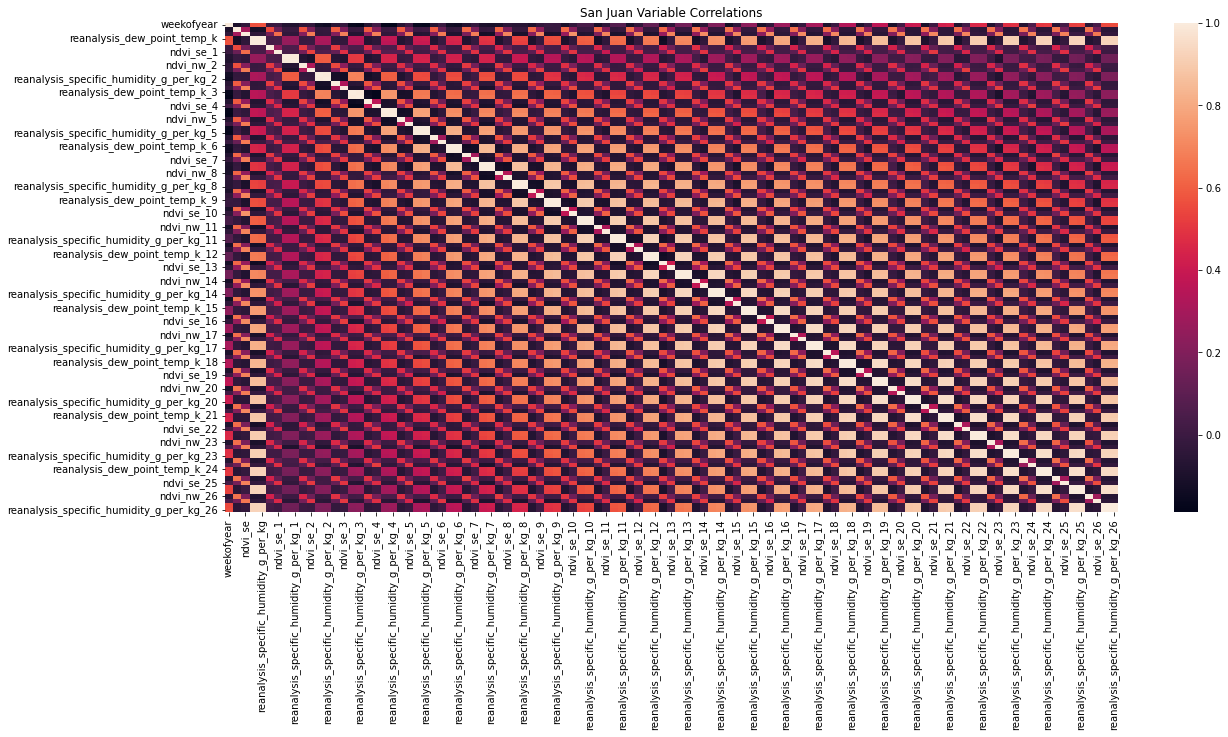

In [9]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [10]:

#XGBRegressor(max_depth=5,learning_rate=.35,n_estimators=50,n_jobs=-1)
#sj_rf = XGBRegressor(max_depth=5,learning_rate=.05,n_estimators=100,n_jobs=-1)
sj_rf = XGBRegressor()                     
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.01151962787168854
24.3350948099564


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [11]:
sj_rf.feature_importances_

array([2.57656537e-02, 1.09943554e-01, 2.36585159e-02, 2.65840050e-02,
       1.42482240e-02, 4.46941219e-02, 2.37641158e-03, 1.75120228e-03,
       2.12112162e-03, 6.31340779e-03, 9.58934706e-03, 1.95817649e-03,
       4.76485991e-04, 2.53297435e-03, 1.57748908e-03, 1.75368506e-03,
       1.54249137e-03, 6.36939425e-04, 1.84245536e-03, 1.91703869e-03,
       4.25412133e-03, 6.58396049e-04, 3.26565024e-03, 2.99422303e-03,
       2.36794120e-03, 1.69860234e-03, 3.18562659e-03, 8.10737628e-03,
       1.02868339e-03, 1.04977807e-03, 2.44914717e-03, 1.18841208e-03,
       2.23305542e-05, 1.55890454e-03, 5.72399120e-04, 1.33597907e-02,
       3.32268327e-03, 4.26507089e-03, 5.01383911e-04, 1.53900795e-02,
       2.66299094e-03, 3.79857305e-03, 5.48739161e-04, 7.14733498e-03,
       1.23158488e-02, 2.85718846e-03, 6.48118183e-03, 2.52732169e-03,
       1.87027454e-02, 6.55622920e-04, 3.95351369e-03, 1.70584989e-03,
       9.41108167e-02, 3.84379597e-03, 2.08364474e-03, 1.51791926e-02,
      

<AxesSubplot:ylabel='cols'>

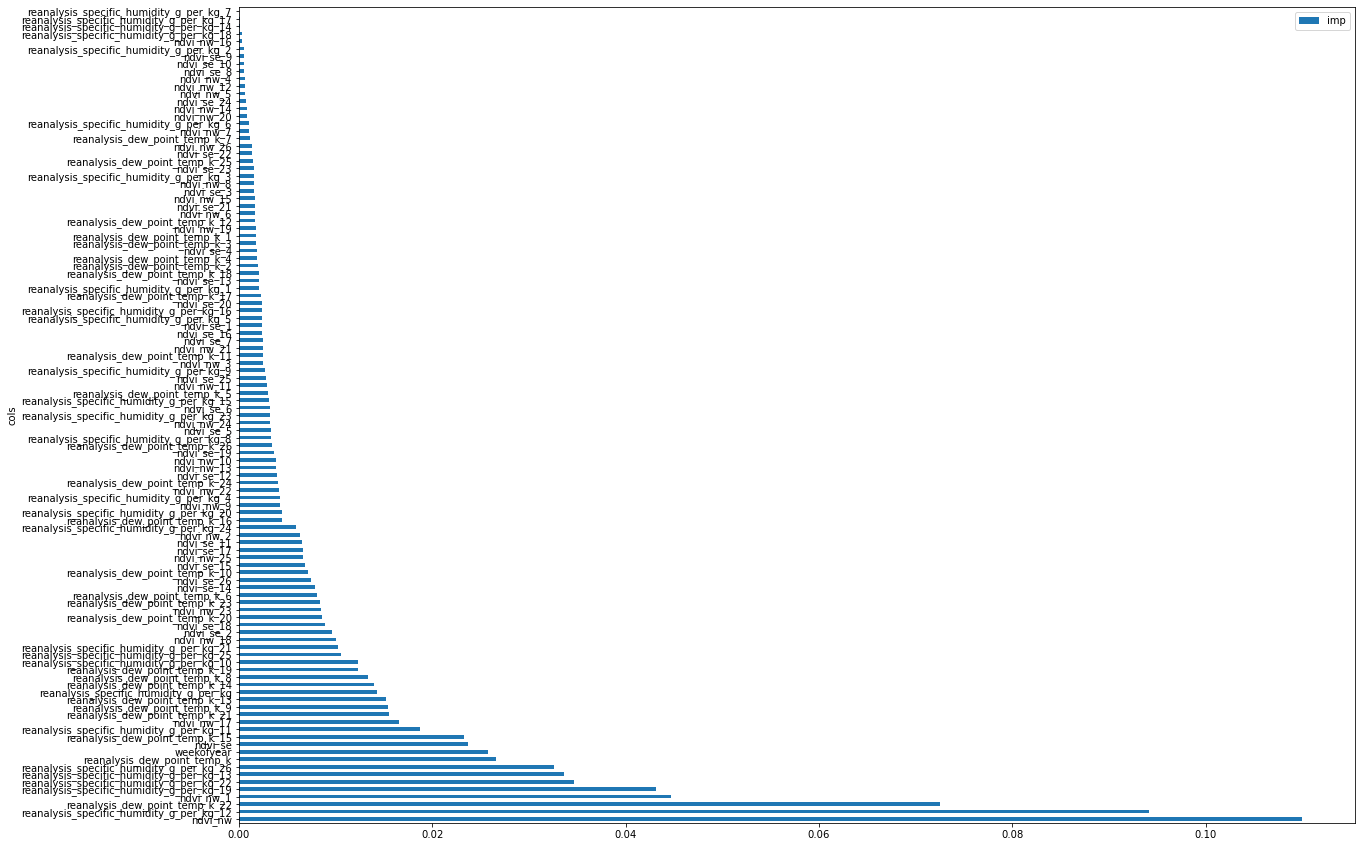

In [12]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [13]:
#iq_rf =  XGBRegressor(max_depth=5,learning_rate=.05,n_estimators=100,n_jobs=-1)
iq_rf =  XGBRegressor()
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.0003182449943817081
7.944328850660568


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
iq_rf.feature_importances_

array([4.06992715e-03, 2.30631884e-03, 3.35372961e-03, 1.56635811e-04,
       3.12401506e-04, 5.63811278e-04, 1.55986869e-03, 7.92952560e-05,
       1.35940907e-03, 6.57302235e-06, 2.63552926e-03, 4.16870229e-04,
       4.73432563e-04, 1.27479343e-05, 2.26918237e-05, 4.48095700e-04,
       4.73406635e-06, 5.53253376e-05, 1.96824619e-03, 8.90449337e-06,
       1.39984491e-04, 5.86674616e-07, 8.13651131e-04, 1.20556592e-07,
       5.44451410e-03, 3.72566836e-04, 1.53876972e-05, 1.08457592e-04,
       4.02503110e-06, 7.87169629e-05, 2.52199708e-04, 2.99205072e-03,
       2.95497307e-06, 3.29460506e-03, 9.55072173e-04, 1.01241167e-03,
       1.29996007e-03, 3.17748357e-03, 2.69345628e-06, 6.04400784e-03,
       1.83816906e-02, 4.28752137e-05, 2.06290249e-04, 5.34538471e-04,
       8.12600181e-03, 3.49783408e-03, 1.26910990e-03, 2.55448663e-06,
       1.06628562e-04, 8.03215429e-04, 6.74727897e-04, 8.75976868e-03,
       6.48603949e-04, 2.30578124e-03, 2.94253789e-03, 1.61174452e-04,
      

<AxesSubplot:ylabel='cols'>

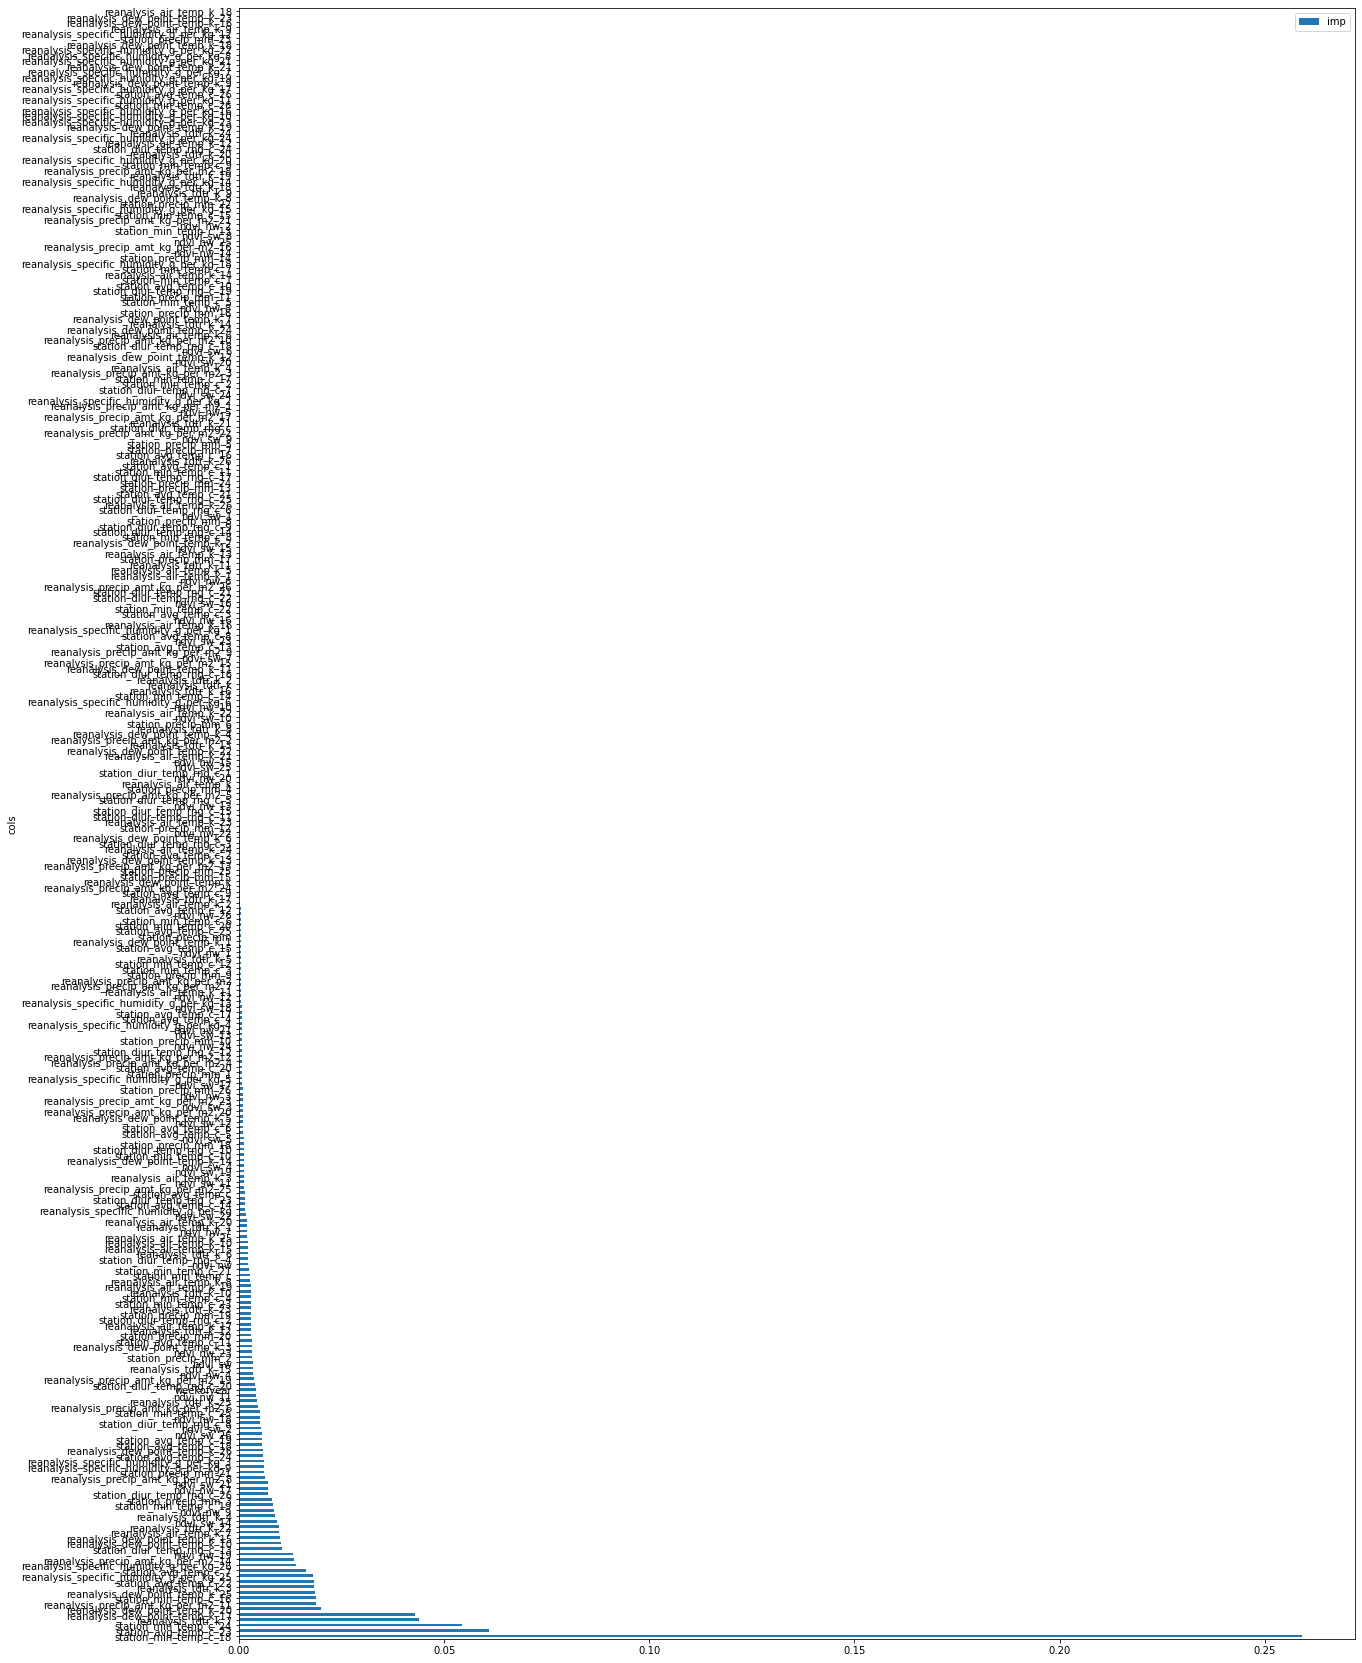

In [15]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


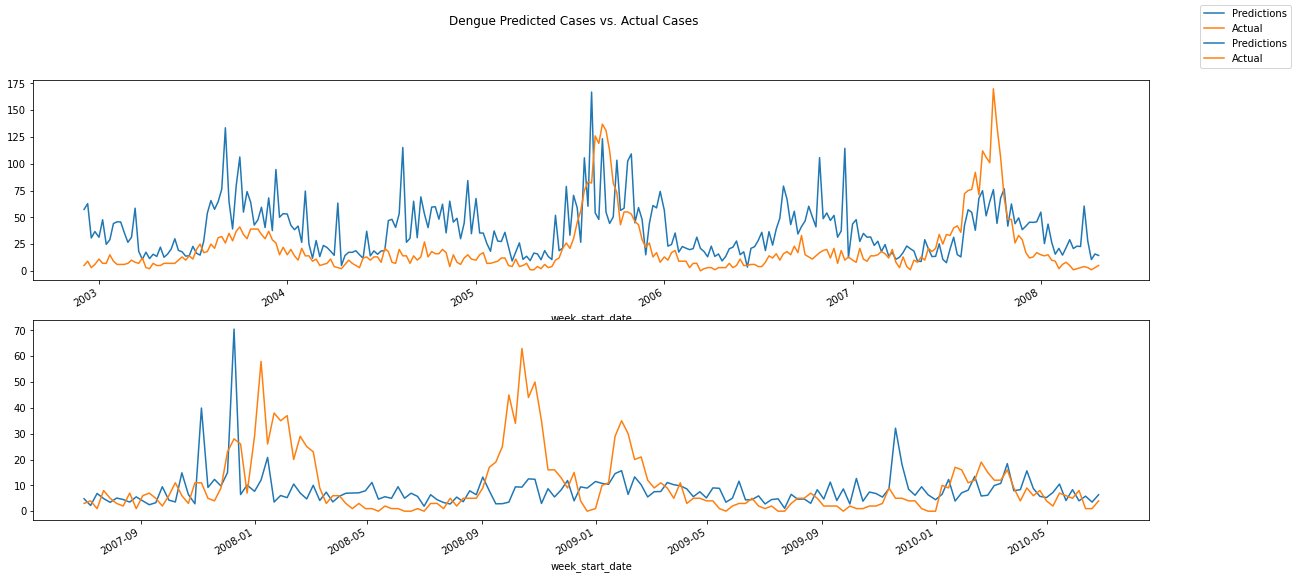

In [16]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [17]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [18]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

In [19]:
sj_X_valid

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,ndvi_nw_2,...,reanalysis_dew_point_temp_k_24,reanalysis_specific_humidity_g_per_kg_24,ndvi_nw_25,ndvi_se_25,reanalysis_dew_point_temp_k_25,reanalysis_specific_humidity_g_per_kg_25,ndvi_nw_26,ndvi_se_26,reanalysis_dew_point_temp_k_26,reanalysis_specific_humidity_g_per_kg_26
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,0.102729,294.527143,15.918571,-0.080356,-0.080643,-0.936836,-0.937541,-0.080686,...,2.045317,2.231751,-0.077554,-0.075725,-2.137126,-2.067045,-0.078116,-0.075257,-1.851881,-1.781458
2008-05-06,19,-0.012400,0.082043,294.395714,15.791429,0.006500,-0.020686,-0.131429,-0.127143,-0.073999,...,1.806007,1.989874,-0.070938,-0.096421,-2.245576,-2.174293,-0.071495,-0.095957,-1.968726,-1.897019
2008-05-13,20,0.061357,0.151083,295.308571,16.674286,0.073757,0.069040,0.912857,0.882857,0.080257,...,2.610982,2.757996,0.002935,-0.027391,-1.309741,-1.271540,0.002382,-0.026931,-1.041285,-1.002580
2008-05-20,21,-0.019867,0.124329,294.402857,15.775714,-0.081223,-0.026755,-0.905714,-0.898571,-0.007467,...,1.597386,1.744689,-0.078172,-0.054156,-2.192478,-2.150216,-0.078721,-0.053701,-1.932415,-1.889569
2008-05-27,22,0.039833,0.062267,294.760000,16.137143,0.059700,-0.062062,0.357143,0.361429,-0.021523,...,1.846647,1.991383,-0.018356,-0.116228,-1.812357,-1.768892,-0.018900,-0.115777,-1.560689,-1.516559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.016183,0.156343,294.675714,15.985714,-0.022408,0.048829,3.688571,3.280000,-0.071058,...,-2.125714,-2.240000,-0.021383,-0.013007,-2.184286,-2.307143,-0.049183,-0.062586,-1.681429,-1.738571
2013-04-02,14,-0.077833,0.204171,294.628571,15.881429,-0.061650,0.047828,-0.047143,-0.104286,-0.084058,...,-1.647143,-1.787143,-0.222333,-0.037343,-2.172857,-2.344286,-0.083033,0.034821,-2.231429,-2.411429
2013-04-09,15,-0.008200,0.192700,294.948571,16.212857,0.069633,-0.011471,0.320000,0.331429,0.007983,...,-2.362857,-2.618571,-0.095400,0.030983,-1.327143,-1.455714,-0.152700,-0.048814,-1.852857,-2.012857


In [20]:
iq_X_valid

,weekofyear,ndvi_nw,ndvi_sw,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,...,ndvi_sw_26,reanalysis_air_temp_k_26,reanalysis_dew_point_temp_k_26,reanalysis_precip_amt_kg_per_m2_26,reanalysis_specific_humidity_g_per_kg_26,reanalysis_tdtr_k_26,station_avg_temp_c_26,station_diur_temp_rng_c_26,station_min_temp_c_26,station_precip_mm_26
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.142500,0.150214,297.648571,296.118571,34.11,17.654286,9.428571,27.440,10.760,...,-0.130986,-1.931819,3.895357,-640.074925,4.059619,-7.037732,-0.314809,7.012553,-13.242227,-56.412629
2010-07-09,27,0.272267,0.320914,298.224286,294.831429,9.10,16.320000,10.157143,27.025,9.625,...,0.039715,-1.329520,2.525733,-640.596452,2.635438,-6.055217,-0.727337,5.626467,-13.007843,-56.553689
2010-07-16,28,0.366457,0.255514,297.955714,296.417143,61.09,18.030000,9.557143,26.950,10.350,...,-0.025684,-1.571507,4.028965,-564.117979,4.255543,-6.401273,-0.799866,6.100381,-12.073460,-40.694748
2010-07-23,29,0.063214,0.081957,295.715714,293.638571,19.60,15.394286,7.828571,26.900,9.700,...,-0.199241,-3.784922,1.167912,-581.119506,1.529934,-7.875901,-0.847394,5.199295,-18.939076,-56.335808
2010-07-30,30,0.327683,0.267914,298.502857,293.892857,18.93,15.468571,11.771429,27.050,11.850,...,-0.013283,-0.971194,1.339717,-557.301033,1.514325,-3.679100,-0.694922,7.098209,-15.704692,-55.976868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.380029,0.383186,297.774286,295.638571,67.60,17.185714,10.100000,27.400,9.050,...,0.033857,-0.115714,-1.878571,-40.100000,-2.157143,3.971429,0.750000,1.400000,-0.300000,-31.000000
2013-06-04,23,0.296343,0.350357,297.167143,295.845714,45.70,17.448571,9.657143,27.520,10.720,...,-0.012557,-1.204286,-1.880000,-40.000000,-2.150000,2.185714,-0.530000,0.695000,-0.800000,18.000000
2013-06-11,24,0.251029,0.249771,295.831429,294.894286,45.22,16.410000,7.385714,27.200,10.075,...,-0.031362,-3.328571,-1.600000,7.220000,-1.791429,-2.785714,-1.400000,-1.125000,-0.600000,63.200000


In [21]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
sj_predictions, iq_predictions

(array([ 42,  47,  17,  37,  40,  21,  11,  12,  12,  17,   9,  11,  34,
         60, 100,  85,  27,  37, 148,  31,  80,  93,  68,  96,  77,  69,
         73,  58,  50,  58,  54,  34,  55,  51,  36,  35,  20,   6,  29,
         31,  14,  14,  17,  15,  21,  15,  15,  11,  14,  13,  16,  11,
         13,  14,  14,  14,  12,  17,  21,   9,  21,  10,  19,  21,  70,
         35,   9,  38,  41,  24,  26,  35,  45,  27,  58,  62,  93,  36,
         47,  71,  52,  27,  45,  40,  52,  41,  44,  70,  36,  44,  55,
         53,  46,  38,  42,  35,  12,  33,  25,  68,  21,  18,  10,  26,
          6,   8,  20,   7,  15,  68,  45,  94,  60,  34,  82, 103,  82,
        105, 152, 187, 184, 156, 177, 128, 121,  36,  44, 128,  76,  69,
         42,  93,  68,  58,  35,  34,  45,  33,  39,  39,  36,  38,  73,
          8,  25,  25,  22,   7,  33,  23,  28,  23,  24,  15,  22,  14,
         10,  18,  18,   9,  20,  13,  25,  48,  91,  49,  42, 108,  53,
         61,  84, 214,  89, 198, 214,  35, 127,  73

In [23]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 24.3350948099564
iq 7.944328850660568


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


sj 17.274501779359433
iq 7.246260500628908

In [24]:
sj_X_test

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,ndvi_nw_2,...,reanalysis_dew_point_temp_k_24,reanalysis_specific_humidity_g_per_kg_24,ndvi_nw_25,ndvi_se_25,reanalysis_dew_point_temp_k_25,reanalysis_specific_humidity_g_per_kg_25,ndvi_nw_26,ndvi_se_26,reanalysis_dew_point_temp_k_26,reanalysis_specific_humidity_g_per_kg_26
week_start_date,,,,,,,,,,,,,,,,,,,,,
2002-12-03,49,-0.120933,0.279086,295.205714,16.578571,-0.083683,0.001757,-0.887143,-0.931429,0.001567,...,-1.191429,-1.222857,-0.178367,0.171771,-1.132857,-1.188571,-0.193133,0.148643,-1.010000,-1.080000
2002-12-10,50,-0.072300,0.199300,294.978571,16.327143,0.048633,-0.079786,-0.227143,-0.251429,-0.035050,...,-1.011429,-1.030000,-0.116767,-0.004914,-1.418571,-1.474286,-0.129733,0.091986,-1.360000,-1.440000
2002-12-17,51,-0.128950,0.185414,294.577143,15.918571,-0.056650,-0.013886,-0.401429,-0.408571,-0.008017,...,-1.485714,-1.480000,-0.246250,-0.028186,-1.412857,-1.438571,-0.173417,-0.018800,-1.820000,-1.882857
2002-12-24,52,-0.252800,0.243433,294.805714,16.160000,-0.123850,0.058019,0.228571,0.241429,-0.180500,...,-1.260000,-1.272857,-0.259300,0.036190,-1.257143,-1.238571,-0.370100,0.029833,-1.184286,-1.197143
2003-01-01,1,-0.045250,0.230457,294.381429,15.845714,0.207550,-0.012976,-0.424286,-0.314286,0.083700,...,-2.038571,-1.962857,-0.064850,-0.023671,-1.684286,-1.587143,-0.051750,0.023214,-1.681429,-1.552857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,13,-0.039900,0.310471,292.095714,13.644286,-0.064350,0.208843,-0.110000,-0.092857,0.101300,...,-4.740000,-4.731429,-0.064667,0.125171,-4.547143,-4.474286,-0.036960,0.157743,-4.414286,-4.337143
2008-04-01,14,-0.016833,0.119371,293.235714,14.662857,0.023067,-0.191100,1.140000,1.018571,-0.041283,...,-3.118571,-3.182857,-0.120833,0.001243,-3.600000,-3.712857,-0.041600,-0.065929,-3.407143,-3.455714
2008-04-08,15,-0.052750,0.137757,292.732857,14.184286,-0.035917,0.018386,-0.502857,-0.478571,-0.012850,...,-3.141429,-3.091429,-0.185417,-0.108186,-3.621429,-3.661429,-0.156750,0.019628,-4.102857,-4.191429


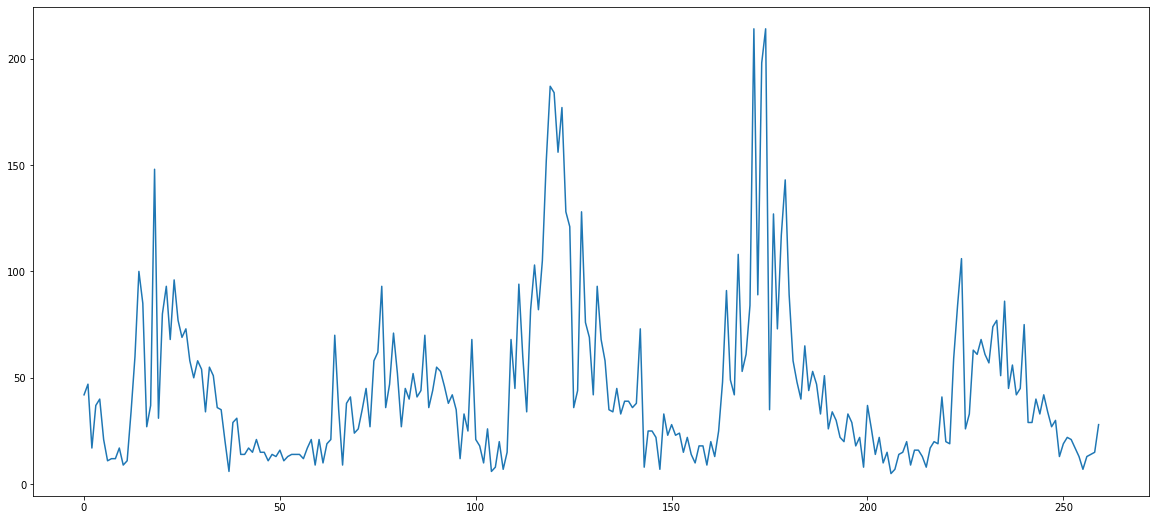

In [25]:
plt.plot(sj_predictions)

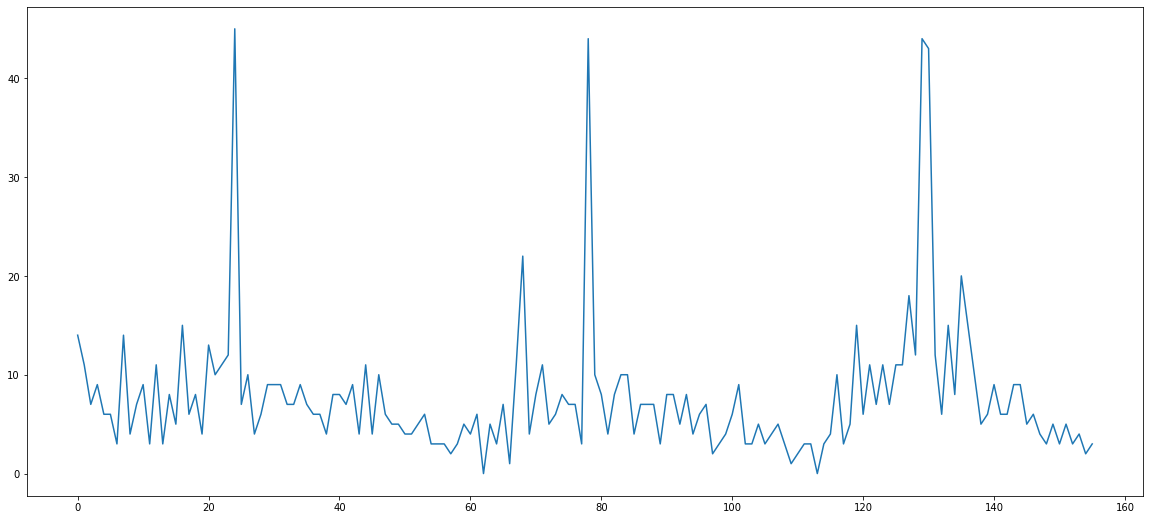

In [26]:
plt.plot(iq_predictions)

<AxesSubplot:xlabel='week_start_date'>

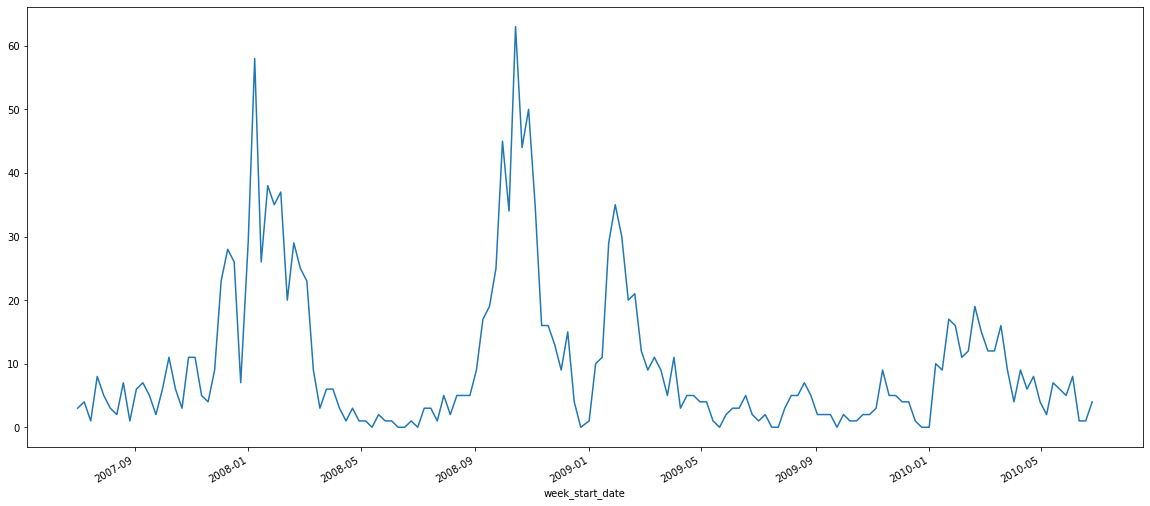

In [27]:
iq_y_test.plot()